In [1]:
%matplotlib inline

In [2]:
from galsize_models.models.load_baseline_catalogs import load_umachine_mock
mock = load_umachine_mock()
print(mock.keys())

Total runtime = 28.22 seconds
['obs_sfr', 'icl', 'upid', 'mpeak', 'sfr', 'halo_id', 'mvir', 'rvir', 'vmax_at_mpeak', 'vx', 'a_first_infall', 'sm', 'vy', 'y', 'x', 'vz', 'z', 'dvmax_zscore', 'obs_sm', 'halo_hostid', 'host_halo_rvir', 'host_halo_mvir', 'ssfr', 'is_main_sequence', 'is_green_valley', 'is_quenched', 'logsm', 'rvir_halo_kpc', 'rvir_halo_kpc_present_day', 'spin_at_infall', 'bt_meert15_random']


In [3]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete, good_profile_mask = load_umachine_sdss_with_meert15()

sdss = full_sdss[behroozi_complete & good_profile_mask]
print(sdss.keys())

disk_dominated_mask = sdss['bulge_to_total_rband_meert15'] < 0.25
bulge_dominated_mask = sdss['bulge_to_total_rband_meert15'] > 0.75
mixed_morphology_mask = ~disk_dominated_mask & ~bulge_dominated_mask


['ra', 'dec', 'z', 'bptclass', 'sm', 'sfr', 'specsfr', 'sm_fib', 'sfr_fib', 'specsfr_fib', 'withinr', 'eligiblehost', 'sm_complete', 'eligiblehost2', 'd4000', 'd4000_sub', 'd4000_n', 'd4000_n_sub', 'has_match', 'logM_mendel13', 'logMB_mendel13', 'logMD_mendel13', 'pps_mendel13', 'type_mendel13', 'deltaBD_mendel13', 'dr7_objID', 'has_meert15_match', 'r50_magr_kpc_meert15', 'Magr_tot_meert15', 'Magr_bulge_meert15', 'Magr_disk_meert15', 'gr_bulge_meert15', 'gr_disk_meert15', 'morph_type_T_meert15', 'gr_kcorr_meert15', 'bulge_to_total_rband_meert15', 'ssfr']


In [28]:
from galsize_models.models.bulge_disk_double_power_law import galaxy_size_vs_rhalo

norm_bulge = 0.002
bulge_to_disk_size_ratio = 1/7.
alpha_bulge = 1.25
alpha_disk = 1
scatter = 0.2

norm_disk = norm_bulge/bulge_to_disk_size_ratio

rvir_halo_kpc = mock['rvir_halo_kpc']
bt = mock['bt_meert15_random']

size_seed=14041

mock['r50_magr_kpc_meert15'] = galaxy_size_vs_rhalo(rvir_halo_kpc, bt, 
                    norm_bulge, norm_disk, 
                     alpha_bulge, alpha_disk, scatter=scatter, seed=size_seed)


bulge_dominated_mask_mock = mock['bt_meert15_random'] > 0.75
disk_dominated_mask_mock = mock['bt_meert15_random'] < 0.25
mixed_morphology_mask_mock = ~disk_dominated_mask_mock & ~bulge_dominated_mask_mock


from scipy.stats import binned_statistic
logsm_bins = np.linspace(9.75, 11.5, 25)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
median_rhalf_bulge_mock, __, __ = binned_statistic(
        mock['obs_sm'][bulge_dominated_mask_mock], 
        mock['r50_magr_kpc_meert15'][bulge_dominated_mask_mock], bins=10**logsm_bins)
median_rhalf_disk_mock, __, __ = binned_statistic(
        mock['obs_sm'][disk_dominated_mask_mock], 
        mock['r50_magr_kpc_meert15'][disk_dominated_mask_mock], bins=10**logsm_bins)
median_rhalf_all_mock, __, __ = binned_statistic(
        mock['obs_sm'], mock['r50_magr_kpc_meert15'], bins=10**logsm_bins)
median_rhalf_mixed_mock, __, __ = binned_statistic(
        mock['obs_sm'][mixed_morphology_mask_mock], 
        mock['r50_magr_kpc_meert15'][mixed_morphology_mask_mock], bins=10**logsm_bins)


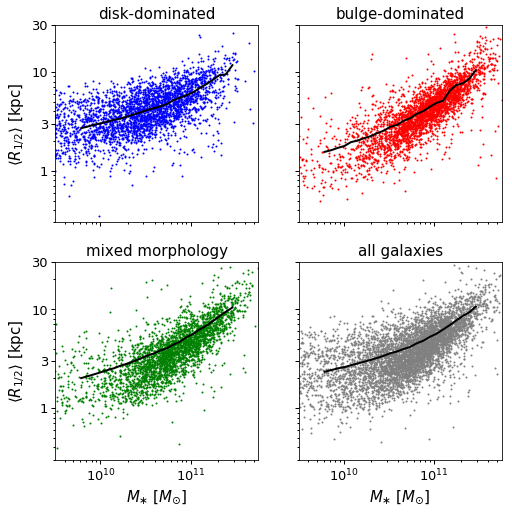

In [29]:
from matplotlib import ticker 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, 
                              figsize=(8, 8))
axes = (ax1, ax2, ax3, ax4)

for ax in axes:
    __=ax.loglog()

__=ax1.scatter(10**sdss['sm'][disk_dominated_mask][::20], 
              sdss['r50_magr_kpc_meert15'][disk_dominated_mask][::20], 
             s=1, color='blue')
__=ax2.scatter(10**sdss['sm'][bulge_dominated_mask][::10], 
              sdss['r50_magr_kpc_meert15'][bulge_dominated_mask][::10], 
             s=1, color='red')
__=ax3.scatter(10**sdss['sm'][mixed_morphology_mask][::40], 
              sdss['r50_magr_kpc_meert15'][mixed_morphology_mask][::40], 
             s=1, color='green')
__=ax4.scatter(10**sdss['sm'][::40], sdss['r50_magr_kpc_meert15'][::40], 
             s=1, color='gray')


__=ax1.plot(10**logsm_mids, median_rhalf_disk_mock, color='k', lw=2)
__=ax2.plot(10**logsm_mids, median_rhalf_bulge_mock, color='k', lw=2)
__=ax3.plot(10**logsm_mids, median_rhalf_mixed_mock, color='k', lw=2)
__=ax4.plot(10**logsm_mids, median_rhalf_all_mock, color='k', lw=2)


xmin, xmax = 10**9.5, 10**11.75
ymin, ymax = 0.3, 30
xlabel = r'$M_{\ast}$ $[M_{\odot}]$'
ylabel = r'$\langle R_{1/2} \rangle$ $[{\rm kpc}]$'
for ax in axes:
    xlim = ax.set_xlim(xmin, xmax)
    ylim = ax.set_ylim(ymin, ymax)
    __=ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    __=ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
    __=ax.set_yticks((1, 3, 10, 30))

ylabel1=ax1.set_ylabel(ylabel)
__=ax3.set_ylabel(ylabel)
xlabel3=ax3.set_xlabel(xlabel)
__=ax4.set_xlabel(xlabel)

title1 = ax1.set_title(r'disk-dominated')
title2 = ax2.set_title(r'bulge-dominated')
title3 = ax3.set_title(r'mixed morphology')
title4 = ax4.set_title(r'all galaxies')

figname = 'size_vs_stellar_mass_multipanel_bt_decomposition.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel1], bbox_inches='tight')


## Test clustering predictions

In [30]:
from galsize_models.measurements import wp_size_ratios_mock

In [31]:
logsm_min = 10.
rp_mids, wp_sm10p0_bulge, wp_sm10p0_bulge_small, wp_sm10p0_bulge_large = wp_size_ratios_mock(mock, logsm_min, 'bulge')
rp_mids, wp_sm10p0_disk, wp_sm10p0_disk_small, wp_sm10p0_disk_large = wp_size_ratios_mock(mock, logsm_min, 'disk')
rp_mids, wp_sm10p0_mixed, wp_sm10p0_mixed_small, wp_sm10p0_mixed_large = wp_size_ratios_mock(mock, logsm_min, 'mixed')

logsm_min = 10.5
rp_mids, wp_sm10p5_bulge, wp_sm10p5_bulge_small, wp_sm10p5_bulge_large = wp_size_ratios_mock(mock, logsm_min, 'bulge')
rp_mids, wp_sm10p5_disk, wp_sm10p5_disk_small, wp_sm10p5_disk_large = wp_size_ratios_mock(mock, logsm_min, 'disk')
rp_mids, wp_sm10p5_mixed, wp_sm10p5_mixed_small, wp_sm10p5_mixed_large = wp_size_ratios_mock(mock, logsm_min, 'mixed')

fracdiff_sm10p0_bulge_mock = (wp_sm10p0_bulge_large-wp_sm10p0_bulge_small)/wp_sm10p0_bulge
fracdiff_sm10p0_disk_mock = (wp_sm10p0_disk_large-wp_sm10p0_disk_small)/wp_sm10p0_disk
fracdiff_sm10p0_mixed_mock = (wp_sm10p0_mixed_large-wp_sm10p0_mixed_small)/wp_sm10p0_mixed

fracdiff_sm10p5_bulge_mock = (wp_sm10p5_bulge_large-wp_sm10p5_bulge_small)/wp_sm10p5_bulge
fracdiff_sm10p5_disk_mock = (wp_sm10p5_disk_large-wp_sm10p5_disk_small)/wp_sm10p5_disk
fracdiff_sm10p5_mixed_mock = (wp_sm10p5_mixed_large-wp_sm10p5_mixed_small)/wp_sm10p5_mixed

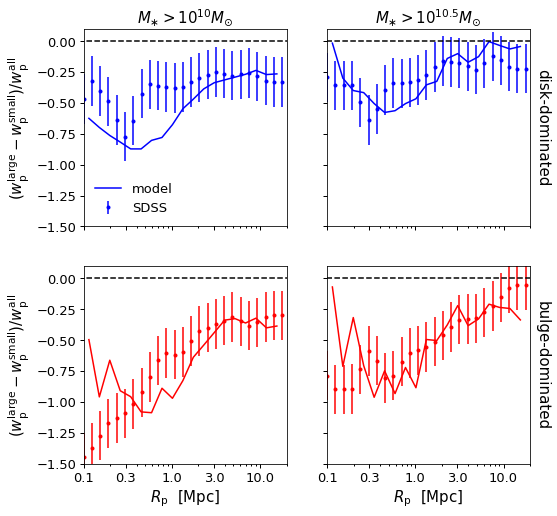

In [32]:
import os
repo_dirname = "/Users/aphearin/work/repositories/python/galsize_models"
output_subdirname = "galsize_models/measurements/data/two_point_functions"
output_dirname = os.path.join(repo_dirname, output_subdirname)

size_fracdiff_sm10p0_meert15_disk_dom = np.load(os.path.join(output_dirname, 'size_fracdiff_sm10p0_meert15_disk_dom.npy'))
size_fracdiff_sm10p0_meert15_bulge_dom = np.load(os.path.join(output_dirname, 'size_fracdiff_sm10p0_meert15_bulge_dom.npy'))
size_fracdiff_sm10p5_meert15_disk_dom = np.load(os.path.join(output_dirname, 'size_fracdiff_sm10p5_meert15_disk_dom.npy'))
size_fracdiff_sm10p5_meert15_bulge_dom = np.load(os.path.join(output_dirname, 'size_fracdiff_sm10p5_meert15_bulge_dom.npy'))

_rp_fname = os.path.join(output_dirname, 'sdss_sm10p0_rp.npy')
sdss_rp = np.load(_rp_fname)


from matplotlib import ticker
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, 
                            sharex=True, sharey=True, figsize=(8, 8))

sdss_errors = np.zeros_like(sdss_rp) + 0.2
__=ax1.errorbar(sdss_rp, size_fracdiff_sm10p0_meert15_disk_dom, sdss_errors, 
                color='blue', fmt='.', label='SDSS')
__=ax2.errorbar(sdss_rp, size_fracdiff_sm10p5_meert15_disk_dom, sdss_errors, 
                color='blue', fmt='.')
__=ax3.errorbar(sdss_rp, size_fracdiff_sm10p0_meert15_bulge_dom, sdss_errors, 
                color='red', fmt='.')
__=ax4.errorbar(sdss_rp, size_fracdiff_sm10p5_meert15_bulge_dom, sdss_errors, 
                color='red', fmt='.')


__=ax1.plot(rp_mids, fracdiff_sm10p0_disk_mock, color='blue', label='model')
__=ax2.plot(rp_mids, fracdiff_sm10p5_disk_mock, color='blue')
__=ax3.plot(rp_mids, fracdiff_sm10p0_bulge_mock, color='red')
__=ax4.plot(rp_mids, fracdiff_sm10p5_bulge_mock, color='red')

leg1 = ax1.legend()


xscale1 = ax1.set_xscale('log')
xscale2 = ax2.set_xscale('log')

__=ax1.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
__=ax2.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
__=ax3.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
__=ax4.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
xmin, xmax = 0.1, 20
ymin, ymax = -1.5, 0.1
xlim1 = ax1.set_xlim(xmin, xmax)
ylim1 = ax1.set_ylim(ymin, ymax)
xlim2 = ax2.set_xlim(xmin, xmax)
ylim2 = ax2.set_ylim(ymin, ymax)

title1 = ax1.set_title(r'$M_{\ast} > 10^{10}M_{\odot}$')
title2 = ax2.set_title(r'$M_{\ast} > 10^{10.5}M_{\odot}$')
xlabel3 = ax3.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
ylabel3 = ax3.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')

__=ax2.yaxis.set_label_position("right")
ylabel2 = ax2.set_ylabel('disk-dominated', rotation=-90, labelpad=20)
__=ax4.yaxis.set_label_position("right")
ylabel4 = ax4.set_ylabel('bulge-dominated', rotation=-90, labelpad=20)

__=ax1.set_xticks((0.1, 0.3, 1, 3, 10))
__=ax2.set_xticks((0.1, 0.3, 1, 3, 10))
ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())

figname = 'size_clustering_ratios_bt_decomposition_model_vs_sdss.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


## Study impact of $R_{1/2} \propto \lambda_{\rm halo}$ assumption

### Build the model

In [36]:
from halotools.empirical_models import conditional_abunmatch

msg = "for logsm = {0:.1f}, num_SDSS = {1}, num_mock = {2}"

logsm_bins = np.linspace(9.75, 11.25, 20)
mock['r50_magr_kpc_meert15_cam'] = mock['r50_magr_kpc_meert15']
for logsm_low,logsm_high in zip(logsm_bins[:-1],logsm_bins[1:]):
    mock_mask = (mock['obs_sm'] >= 10**logsm_low)& (mock['obs_sm'] < 10**logsm_high)
    mock_mask *= (mock['bt_meert15_random'] < 0.25)
    mock_mask *= (mock['upid'] == -1)
    mock_sample = mock[mock_mask]
    sdss_mask = (sdss['sm'] >= logsm_low)& (sdss['sm'] < logsm_high)
    sdss_mask *= (sdss['bulge_to_total_rband_meert15'] < 0.25)
    sdss_sample = sdss[sdss_mask]
    haloprop = mock_sample['spin_at_infall']
    galprop = sdss_sample['r50_magr_kpc_meert15']
#     print(msg.format(logsm_low, len(sdss_sample),len(mock_sample)))
    model_galprop = conditional_abunmatch(haloprop, galprop)
    mock['r50_magr_kpc_meert15_cam'][mock_mask] = model_galprop


### Impact of $R_{1/2} \propto \lambda_{\rm halo}$ on clustering ratios

In [37]:
logsm_min = 10.
rp_mids, wp_sm10p0_bulge2, wp_sm10p0_bulge_small2, wp_sm10p0_bulge_large2 = wp_size_ratios_mock(mock, logsm_min, 'bulge',size_key='r50_magr_kpc_meert15_cam')
rp_mids, wp_sm10p0_disk2, wp_sm10p0_disk_small2, wp_sm10p0_disk_large2 = wp_size_ratios_mock(mock, logsm_min, 'disk',size_key='r50_magr_kpc_meert15_cam')
rp_mids, wp_sm10p0_mixed2, wp_sm10p0_mixed_small2, wp_sm10p0_mixed_large2 = wp_size_ratios_mock(mock, logsm_min, 'mixed',size_key='r50_magr_kpc_meert15_cam')

logsm_min = 10.5
rp_mids, wp_sm10p5_bulge2, wp_sm10p5_bulge_small2, wp_sm10p5_bulge_large2 = wp_size_ratios_mock(mock, logsm_min, 'bulge',size_key='r50_magr_kpc_meert15_cam')
rp_mids, wp_sm10p5_disk2, wp_sm10p5_disk_small2, wp_sm10p5_disk_large2 = wp_size_ratios_mock(mock, logsm_min, 'disk',size_key='r50_magr_kpc_meert15_cam')
rp_mids, wp_sm10p5_mixed2, wp_sm10p5_mixed_small2, wp_sm10p5_mixed_large2 = wp_size_ratios_mock(mock, logsm_min, 'mixed',size_key='r50_magr_kpc_meert15_cam')

fracdiff_sm10p0_bulge_mock2 = (wp_sm10p0_bulge_large2-wp_sm10p0_bulge_small2)/wp_sm10p0_bulge2
fracdiff_sm10p0_disk_mock2 = (wp_sm10p0_disk_large2-wp_sm10p0_disk_small2)/wp_sm10p0_disk2
fracdiff_sm10p0_mixed_mock2 = (wp_sm10p0_mixed_large2-wp_sm10p0_mixed_small2)/wp_sm10p0_mixed2

fracdiff_sm10p5_bulge_mock2 = (wp_sm10p5_bulge_large2-wp_sm10p5_bulge_small2)/wp_sm10p5_bulge2
fracdiff_sm10p5_disk_mock2 = (wp_sm10p5_disk_large2-wp_sm10p5_disk_small2)/wp_sm10p5_disk2
fracdiff_sm10p5_mixed_mock2 = (wp_sm10p5_mixed_large2-wp_sm10p5_mixed_small2)/wp_sm10p5_mixed2

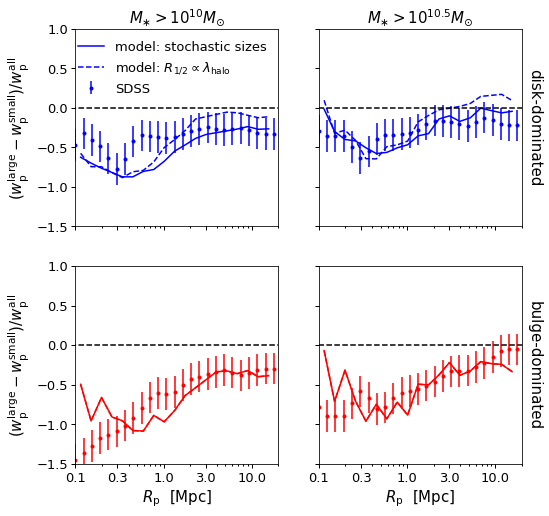

In [38]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, 
                            sharex=True, sharey=True, figsize=(8, 8))

sdss_errors = np.zeros_like(sdss_rp) + 0.2
__=ax1.errorbar(sdss_rp, size_fracdiff_sm10p0_meert15_disk_dom, sdss_errors, 
                color='blue', fmt='.', label='SDSS')
__=ax2.errorbar(sdss_rp, size_fracdiff_sm10p5_meert15_disk_dom, sdss_errors, 
                color='blue', fmt='.')
__=ax3.errorbar(sdss_rp, size_fracdiff_sm10p0_meert15_bulge_dom, sdss_errors, 
                color='red', fmt='.')
__=ax4.errorbar(sdss_rp, size_fracdiff_sm10p5_meert15_bulge_dom, sdss_errors, 
                color='red', fmt='.')


__=ax1.plot(rp_mids, fracdiff_sm10p0_disk_mock, color='blue', 
            label='model: stochastic sizes')
__=ax2.plot(rp_mids, fracdiff_sm10p5_disk_mock, color='blue')
__=ax3.plot(rp_mids, fracdiff_sm10p0_bulge_mock, color='red')
__=ax4.plot(rp_mids, fracdiff_sm10p5_bulge_mock, color='red')
__=ax1.plot(rp_mids, fracdiff_sm10p0_disk_mock2,'--', color='blue', 
            label=r'model: $R_{1/2}\propto\lambda_{\rm halo}$')
__=ax2.plot(rp_mids, fracdiff_sm10p5_disk_mock2,'--', color='blue')
__=ax3.plot(rp_mids, fracdiff_sm10p0_bulge_mock2,'--', color='red')
__=ax4.plot(rp_mids, fracdiff_sm10p5_bulge_mock2,'--', color='red')

leg1 = ax1.legend()


xscale1 = ax1.set_xscale('log')
xscale2 = ax2.set_xscale('log')

__=ax1.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
__=ax2.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
__=ax3.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
__=ax4.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')
xmin, xmax = 0.1, 20
ymin, ymax = -1.5, 1
xlim1 = ax1.set_xlim(xmin, xmax)
ylim1 = ax1.set_ylim(ymin, ymax)
xlim2 = ax2.set_xlim(xmin, xmax)
ylim2 = ax2.set_ylim(ymin, ymax)

title1 = ax1.set_title(r'$M_{\ast} > 10^{10}M_{\odot}$')
title2 = ax2.set_title(r'$M_{\ast} > 10^{10.5}M_{\odot}$')
xlabel3 = ax3.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
ylabel3 = ax3.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')

__=ax2.yaxis.set_label_position("right")
ylabel2 = ax2.set_ylabel('disk-dominated', rotation=-90, labelpad=20)
__=ax4.yaxis.set_label_position("right")
ylabel4 = ax4.set_ylabel('bulge-dominated', rotation=-90, labelpad=20)

__=ax1.set_xticks((0.1, 0.3, 1, 3, 10))
__=ax2.set_xticks((0.1, 0.3, 1, 3, 10))
ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())

figname = 'size_clustering_ratios_bt_decomposition_spin_size_correlation.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


### Impact of $R_{1/2} \propto \lambda_{\rm halo}$ on central lensing

In [39]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)

from halotools.mock_observables import return_xyz_formatted_array
px = halocat.ptcl_table['x']
py = halocat.ptcl_table['y']
pz = halocat.ptcl_table['z']

particles = np.vstack((px,py,pz)).T
particle_masses = np.zeros(len(particles)) + halocat.particle_mass
total_num_ptcl_in_snapshot = halocat.num_ptcl_per_dim**3
downsampling_factor = total_num_ptcl_in_snapshot/float(len(particles))
rp_bins = np.logspace(-1, 1, 10)
period = halocat.Lbox

In [40]:
from galsize_models.measurements.split_sdss_sample_rhalf import mock_sample_below_median_size

disk_mask = mock['bt_meert15_random'] < 0.25
mock_disks = mock[disk_mask]

_small_size_mask = mock_sample_below_median_size(mock_disks,size_key='r50_magr_kpc_meert15')
small_disks = mock_disks[_small_size_mask]
large_disks = mock_disks[~_small_size_mask]

_small_size_mask2 = mock_sample_below_median_size(mock_disks,size_key='r50_magr_kpc_meert15_cam')
small_disks_cam = mock_disks[_small_size_mask2]
large_disks_cam = mock_disks[~_small_size_mask2]


In [41]:

small_disks_pos = return_xyz_formatted_array(small_disks['x'],small_disks['y'],small_disks['z'],
                                           velocity=small_disks['vz'],
                                           redshift=0., cosmology=halocat.cosmology,
                                           velocity_distortion_dimension='z', period=period)
large_disks_pos = return_xyz_formatted_array(large_disks['x'],large_disks['y'],large_disks['z'],
                                           velocity=large_disks['vz'],
                                           redshift=0.,cosmology=halocat.cosmology,
                                           velocity_distortion_dimension='z',period=period)

In [42]:

small_disks_cam_pos = return_xyz_formatted_array(small_disks_cam['x'],small_disks_cam['y'],small_disks_cam['z'],
                                           velocity=small_disks_cam['vz'],
                                           redshift=0.,cosmology=halocat.cosmology,
                                           velocity_distortion_dimension='z', period=period)
large_disks_cam_pos = return_xyz_formatted_array(large_disks_cam['x'],large_disks_cam['y'],large_disks_cam['z'],
                                           velocity=large_disks_cam['vz'],
                                           redshift=0.,cosmology=halocat.cosmology,
                                           velocity_distortion_dimension='z',
                                                period=period)

In [43]:
from halotools.mock_observables import delta_sigma
rp_mids, ds_small_disks = delta_sigma(small_disks_pos, particles, particle_masses, 
                                      downsampling_factor, rp_bins, period)
rp_mids, ds_large_disks = delta_sigma(large_disks_pos, particles, particle_masses, 
                                      downsampling_factor, rp_bins, period)
ds_small_disks *= (halocat.cosmology.h/1e12)
ds_large_disks *= (halocat.cosmology.h/1e12)

rp_mids, ds_small_disks_cam = delta_sigma(small_disks_cam_pos, particles, particle_masses, 
                                      downsampling_factor, rp_bins, period)
rp_mids, ds_large_disks_cam = delta_sigma(large_disks_cam_pos, particles, particle_masses, 
                                      downsampling_factor, rp_bins, period)
ds_small_disks_cam *= (halocat.cosmology.h/1e12)
ds_large_disks_cam *= (halocat.cosmology.h/1e12)

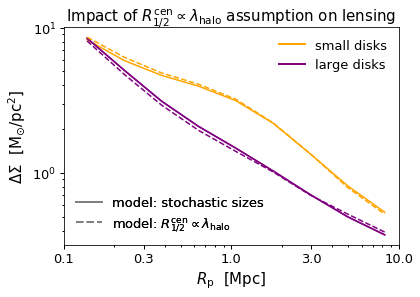

In [44]:
fig, ax = plt.subplots(1, 1)

__=ax.loglog()

__=ax.plot(rp_mids, ds_small_disks, label='small disks', color='orange')
__=ax.plot(rp_mids, ds_large_disks, label='large disks', color='purple')
__=ax.plot(rp_mids, ds_large_disks, label='model: stochastic sizes', color='purple')

__=ax.plot(rp_mids, ds_small_disks_cam, '--', color='orange', 
           label=r'model: $R^{\rm cen}_{1/2}\propto\lambda_{\rm halo}$')
__=ax.plot(rp_mids, ds_large_disks_cam, '--', color='purple')

title=r'Impact of $R^{\rm cen}_{1/2}\propto\lambda_{\rm halo}$ assumption on lensing'
ax_title = ax.set_title(title)

xlim = ax.set_xlim(0.1, 10)
xlabel = ax.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
ylabel = ax.set_ylabel(r'$\Delta\Sigma$  $[{\rm M_{\odot}/pc^2}]$')

__=ax.set_xticks((0.1, 0.3, 1, 3, 10))
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())

from matplotlib import lines as mlines
solid_line1 = mlines.Line2D([], [], ls='-', c='orange', linewidth=2, label='small disks')
solid_line2 = mlines.Line2D([], [], ls='-', c='purple', linewidth=2, label='large disks')
first_legend = plt.legend(handles=[solid_line1, solid_line2], loc=1, fontsize=13)
__=ax.add_artist(first_legend)

dashed_line1 = mlines.Line2D([], [], ls='-', c='gray', linewidth=2, 
                             label='model: stochastic sizes')
dashed_line2 = mlines.Line2D([], [], ls='--', c='gray', linewidth=2, 
                             label=r'model: $R^{\rm cen}_{1/2}\propto\lambda_{\rm halo}$')
second_legend = plt.legend(handles=[dashed_line1, dashed_line2], loc=3, fontsize=13)
__=ax.add_artist(second_legend)

figname = 'central_lensing_spin_size_correlation.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')
